# Faire - The Online Wholesale Marketplace & Store

Welcome! Lets build a new search ranking model.

### Description

Knowing whether a Product in Search will be bought in advance could provide huge business value to Faire. This task is very important for purchase prediction as well as for short term user engagement prediction.

- In this dataset we have sampled ~20k rows from Faire search logs. The dataset is anonymized. Before describing the dataset, lets give some preliminary knowledge of how Faire Wholesale MarketPlace Search works. Faire is a two-sided marketplace where retailers come to shop wholesale products from brands. When a retailer makes a search on the site, we call that a search request. The response is a page with many products. We assign a `request_id` to this search request response, and different pages (page number 1, 2, 3...) from the same search have different `request_id`s (i.e. `request_id` is more of a "page id" than a "search session id"). Each row in this dataset represents one single product that was impressed for that `request_id`. For each request_id you can have many results (due to this being a random sample some of them might be missed in a some cases). 

- Each row contains the following fields: `request_id`, `retailer_token` (anonymzed user token), `query_text` (the actual search string), `page_number`, `page_size`, `position`, `filter_string` (filters applied on top of the search), `has_product_click` (was it clicked or not). 
- We have some features from our feature store (computed using data from before the search timestamp): anything starting with `product.` is a product-level feature. We have also a few personalization features in this dataset, anything starting with `retailerbrand.` is a personalization feature and relates to a particular retailer:brand pair. 
- Note that we have personalization features only at the level of retailer(user) and the brand the product belongs to. Brands usually have many products in our marketplace, so Product <-> Brand mapping is Many:1.

### Tasks
In approximately 1 hour, please do the following:
- Please build first a ranking model using the provided dataset and evaluate it. 
- If there is time, please implement 1 or 2 additional features, and list up to 10 more features (without implementing them).
- If there is time, please give us an idea of the next steps, how would you improve this model if you had 1 week more, 1 month more, or 3 months more?

Please write as many comments or communicate out loud your thought process. Once your time allocation is up, please send back the completed notebook in .ipynb and .pdf format

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

In [2]:
data = pd.read_csv("datasets/faire-ml-rank-small.csv")
data.head(3)

,Unnamed: 0.1,Unnamed: 0,product.product_brand_page_click_to_cart_rate,product.product_brand_page_impression_to_click_rate,product.product_click_to_cart_rate_4w,product.product_impression_to_click_rate_4w,product.product_is_high_sell_through,product.product_num_cart_adds_4w,product.product_num_clicks_4w,product.product_num_impressions_4w,...,description,has_product_click,created_at_a,query_text,filter_string,page_number,page_size,position,retailer_token_anon,request_id_anon
0,26152,26152,1.0708,0.0133,NaN,NaN,0.0,NaN,NaN,303.0,...,Hat-leopard visor sun hat.,0,2020-05-31 00:22:33.18,sun hat,NaN,0.0,48,23.0,188,1433
1,26890,26890,1.9197,0.0134,NaN,NaN,0.0,NaN,NaN,77.0,...,"Offbeat, cheeky and distinctive greeting cards...",0,2020-05-31 01:21:00.418,beach,NaN,23.0,24,559.0,132,703
2,41983,41983,0.6080,0.0423,NaN,NaN,0.0,NaN,NaN,50.0,...,"Selene, considered the human personification o...",0,2020-05-31 23:34:57.391,gold love necklace,NaN,1.0,48,58.0,81,516


In [3]:
# filter out features which have less than 1% non null values
def filterFeaturesWith1PNulls(data):
    not_null_percentage = data.notnull().mean()*100
    return data.loc[:,not_null_percentage >= 1]

# FIlter out features which have constant value
length = len(data)
uniques_percetage = 100*data.nunique()/length
print(uniques_percetage.sort_values())

product.product_is_high_sell_through                                            0.005
has_product_click                                                               0.010
retailerbrand.retailer_brand_num_brand_orders_1w                                0.015
page_size                                                                       0.025
retailerbrand.retailer_brand_num_brand_orders_4w                                0.030
retailerbrand.retailer_brand_num_brand_orders_12w                               0.040
product.product_num_clicks_4w                                                   0.050
retailerbrand.retailer_brand_num_products_added_to_cart_1w                      0.100
retailerbrand.retailer_brand_num_brand_visits_1w                                0.125
retailerbrand.retailer_brand_num_products_added_to_cart_4w                      0.165
retailerbrand.retailer_brand_num_products_added_to_cart_12w                     0.205
retailerbrand.retailer_brand_num_brand_visits_4w      

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 50 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   Unnamed: 0.1                                                                20000 non-null  int64  
 1   Unnamed: 0                                                                  20000 non-null  int64  
 2   product.product_brand_page_click_to_cart_rate                               19813 non-null  float64
 3   product.product_brand_page_impression_to_click_rate                         19815 non-null  float64
 4   product.product_click_to_cart_rate_4w                                       301 non-null    float64
 5   product.product_impression_to_click_rate_4w                                 4555 non-null   float64
 6   product.product_is_high_sell_through          

In [5]:
def match_title(row):
    if row['query_text'] in row['title']:
        return 1.0
    else:
        return 0.0

def match_desc(row):
    if row['query_text'] in row['description']:
        return 1.0
    else:
        return 0.0
data['description'] = data['description'].fillna("")
data['title_match'] = data.apply(match_title, axis=1)
data['description_match'] = data.apply(match_desc, axis=1)

# Drop irrelevant features

In [6]:
# Drop columns that are not needed
ignored_features = [
    'Unnamed: 0.1', 
    'Unnamed: 0', 
    'rand', 
    'title', 
    'description', 
    'created_at_a', 
    'query_text',
    'filter_string', 
    'retailer_token_anon', 
]
  
lesser_important_features = [
    'product.product_is_high_sell_through',
    'title_match',
    # 'description_match',
    # 'product.product_num_clicks_4w',
]

features = data.drop(
    (ignored_features + lesser_important_features),
    axis=1
)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   product.product_brand_page_click_to_cart_rate                               19813 non-null  float64
 1   product.product_brand_page_impression_to_click_rate                         19815 non-null  float64
 2   product.product_click_to_cart_rate_4w                                       301 non-null    float64
 3   product.product_impression_to_click_rate_4w                                 4555 non-null   float64
 4   product.product_num_cart_adds_4w                                            301 non-null    float64
 5   product.product_num_clicks_4w                                               21 non-null     float64
 6   product.product_num_impressions_4w            

In [7]:
features = features.fillna(0.0)
features.describe()

,product.product_brand_page_click_to_cart_rate,product.product_brand_page_impression_to_click_rate,product.product_click_to_cart_rate_4w,product.product_impression_to_click_rate_4w,product.product_num_cart_adds_4w,product.product_num_clicks_4w,product.product_num_impressions_4w,product.product_num_search_excess_cart_adds_4w,product.product_num_search_excess_clicks_4w,product.product_num_search_impressions_4w,...,retailerbrand.retailer_brand_num_products_added_to_cart_4w,retailerbrand.retailer_last_added_brands_brand_lightfm_cosine_similarity,retailerbrand.retailer_last_ordered_brands_brand_lightfm_cosine_similarity,retailerbrand.retailer_last_visited_brands_brand_lightfm_cosine_similarity,has_product_click,page_number,page_size,position,request_id_anon,description_match
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.409135,0.020018,0.005969,0.007877,1.226200,0.607550,318.792450,0.112913,0.996092,194.637700,...,0.650100,0.569509,0.535829,0.577731,0.04195,2.074800,43.052200,97.561550,732.618250,0.160550
std,0.303369,0.022389,0.062568,0.020436,15.498253,19.763362,432.269425,2.196843,10.287815,587.641705,...,3.577487,0.494474,0.498077,0.493752,0.20048,6.625179,10.839181,225.353999,427.707775,0.367125
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-81.254300,-209.299100,0.000000,...,0.000000,-0.673838,-0.670320,-0.671783,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.204500,0.008375,0.000000,0.000000,0.000000,0.000000,93.000000,-0.204250,-0.616250,31.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,48.000000,14.000000,358.000000,0.000000
50%,0.334500,0.014100,0.000000,0.000000,0.000000,0.000000,194.000000,-0.081000,-0.176400,69.000000,...,0.000000,0.999061,0.998099,0.999138,0.00000,0.000000,48.000000,37.000000,735.000000,0.000000
75%,0.525425,0.023800,0.000000,0.000000,0.000000,0.000000,373.000000,-0.015800,0.676900,159.000000,...,0.000000,0.999721,0.999703,0.999712,0.00000,2.000000,50.000000,89.000000,1104.250000,0.000000
max,2.541900,0.494500,2.410700,0.373500,569.000000,1029.000000,5030.000000,42.163700,356.396100,9644.000000,...,165.000000,1.000000,1.000000,1.000000,1.00000,172.000000,50.000000,5022.000000,1462.000000,1.000000


# Feature Scaling and Normalization to Zero Mean

In [8]:
from sklearn.preprocessing import StandardScaler

ignore_columns = {'request_id_anon', 'has_product_click', 'title_match', 'description_match'}

scaler = StandardScaler()
for column in features.columns:
    if column in ignore_columns:
        continue
    scaler = StandardScaler()
    features[column] = scaler.fit_transform(features[[column]])    

features['has_product_click'].value_counts()

has_product_click
0    19161
1      839
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

request_ids = features['request_id_anon'].unique()
RANDOM_STATE = 42
TEST_SIZE = 0.2

r_train, r_test = train_test_split(request_ids, test_size=TEST_SIZE, random_state=RANDOM_STATE)
# r_train.shape, r_test.shape
X_train = features[features['request_id_anon'].isin(r_train)].drop(['request_id_anon'], axis=1)
X_test = features[features['request_id_anon'].isin(r_test)].drop(['request_id_anon'], axis=1)

Y_train = X_train['has_product_click'].astype(int)
X_train = X_train.drop('has_product_click', axis=1)

Y_test = X_test['has_product_click'].astype(int)
X_test = X_test.drop('has_product_click', axis=1)
X_train.shape, Y_test.shape

((15998, 39), (4002,))

# Ranking Metrics

In [10]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, confusion_matrix, f1_score, classification_report, average_precision_score

def metrics(model):

    Y_train_pred = model.predict(X_train)
    precision = precision_score(Y_train, Y_train_pred)
    recall = recall_score(Y_train, Y_train_pred)
    pred_proba = model.predict_proba(X_train)[:, 1]
    p,r,_ = precision_recall_curve(Y_train, pred_proba)
    pr_auc = auc(r, p)
    report = classification_report(Y_train, Y_train_pred)
    # print(f"\n\n----- Training Metrics -------")
    # print(f"PR-AUC: {pr_auc}")
    # print(f"Precision: {precision}")
    # print(f"Recall: {recall}")
    # print(f"{report}")


    Y_pred = model.predict(X_test)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    pred_proba = model.predict_proba(X_test)[:, 1]
    p,r,_ = precision_recall_curve(Y_test, pred_proba)
    pr_auc = auc(r, p)
    report = classification_report(Y_test, Y_pred)
    aps = average_precision_score(Y_test, Y_pred)

    print(f"\n----- Testing Metrics -------")
    print(f"PR-AUC: {pr_auc}")
    print(f"AveragePrecision: {aps}")
    # print(f"Precision: {precision}")
    # print(f"Recall: {recall}")
    # print(report)
    
    if isinstance(model, DecisionTreeClassifier):
        featureImportances = model.feature_importances_
        depth = model.get_depth()
        leaves = model.get_n_leaves()
        print(f"Tree:  Max Depth: {depth}    Leaves: {leaves}")
    elif isinstance(model, RandomForestClassifier) or isinstance(model, GradientBoostingClassifier):
        featureImportances = model.feature_importances_
    elif isinstance(model, LogisticRegression):
        featureImportances = model.coef_[0]

    features = X_train.columns
    features = list(zip(features, featureImportances))
    features.sort(key=lambda x: x[1], reverse=True)

    # print(f"\n --- Top 5 Features ------ ")
    # for i in range(5):
    #     print(f"{features[i][0]}:\t{round(features[i][1], 4)}")

    
    # print(f"\n --- Bottom 5 Features ------ ")
    # for i in range(1, 5):
    #     print(f"{features[-i][0]}:\t{round(features[-i][1], 4)}")



# Model Training

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier


def train_models():
    # lr = LogisticRegression(
    #     max_iter=200,
    #     random_state = RANDOM_STATE
    # )
    # lr.fit(X_train, Y_train)

    # metrics(lr)

    # dtc = DecisionTreeClassifier(
    #     random_state=RANDOM_STATE
    # )
    # dtc.fit(X_train, Y_train)
    # metrics(dtc)

    # rf = RandomForestClassifier(
    #     n_estimators=200,
    #     random_state=RANDOM_STATE,
    #     max_depth=40,
    #     min_samples_split=4,
    #     min_samples_leaf=2,
    #     n_jobs=4,
    #     criterion='entropy'
    # )
    # rf.fit(X_train, Y_train)
    # metrics(rf)

    # gbc = GradientBoostingClassifier(
    #     random_state=RANDOM_STATE,
    # )  
    # gbc.fit(X_train, Y_train)
    # metrics(gbc)


    gbc = GradientBoostingClassifier(
        n_estimators=100,
        min_samples_split=4, 
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
    )  
    gbc.fit(X_train, Y_train)
    metrics(gbc)




# Cross Validation using 5 splits

In [12]:
from sklearn.model_selection import GroupKFold

X = features.drop(columns=['has_product_click', 'request_id_anon'])
Y = features['has_product_click'].astype(int)

groups = features['request_id_anon']
gkf = GroupKFold(n_splits=5)

for train_idx, test_idx in gkf.split(X, Y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    train_models()
    





----- Testing Metrics -------
PR-AUC: 0.11123164528147761
AveragePrecision: 0.03772413793103448

----- Testing Metrics -------
PR-AUC: 0.11594215748252254
AveragePrecision: 0.05044204737732657

----- Testing Metrics -------
PR-AUC: 0.12081235964308383
AveragePrecision: 0.041725806451612904

----- Testing Metrics -------
PR-AUC: 0.13304029474855408
AveragePrecision: 0.046824858757062146

----- Testing Metrics -------
PR-AUC: 0.11037967393697437
AveragePrecision: 0.04421320346320347


# Hyper Parameter Search with Cross Validation

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer




def pr_auc_score(y_true, y_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    return  auc(recall, precision)

pr_auc_scorer = make_scorer(pr_auc_score, response_method="predict_proba")

param_grid = {
    # DecisionTree Hyperparameters
    # 'criterion': ['gini', 'entropy'],
    # 'max_depth': [10, 20, 30, 40],
    
    # GradientBoostedTrees Hyperparameters
    'n_estimators': [100, 200],
    'criterion': ["friedman_mse"],
    "learning_rate": [0.01, 0.05],
    'max_depth': [3, 5],

    # Common Hyperparameters
   
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'random_state': [42]
}


# dtc = DecisionTreeClassifier()
dtc = GradientBoostingClassifier()

grid_search = GridSearchCV(
    estimator=dtc, 
    param_grid=param_grid, 
    cv=gkf, # Cross validation with 5 splits
    scoring=pr_auc_scorer, # PR AUC
    n_jobs = 10 # Parallel Execution
)


grid_search.fit(X, Y, groups=groups)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best PR-AUC Score:", grid_search.best_score_)



Best Hyperparameters: {'criterion': 'friedman_mse', 'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}
Best PR-AUC Score: 0.1278794460389217


[]

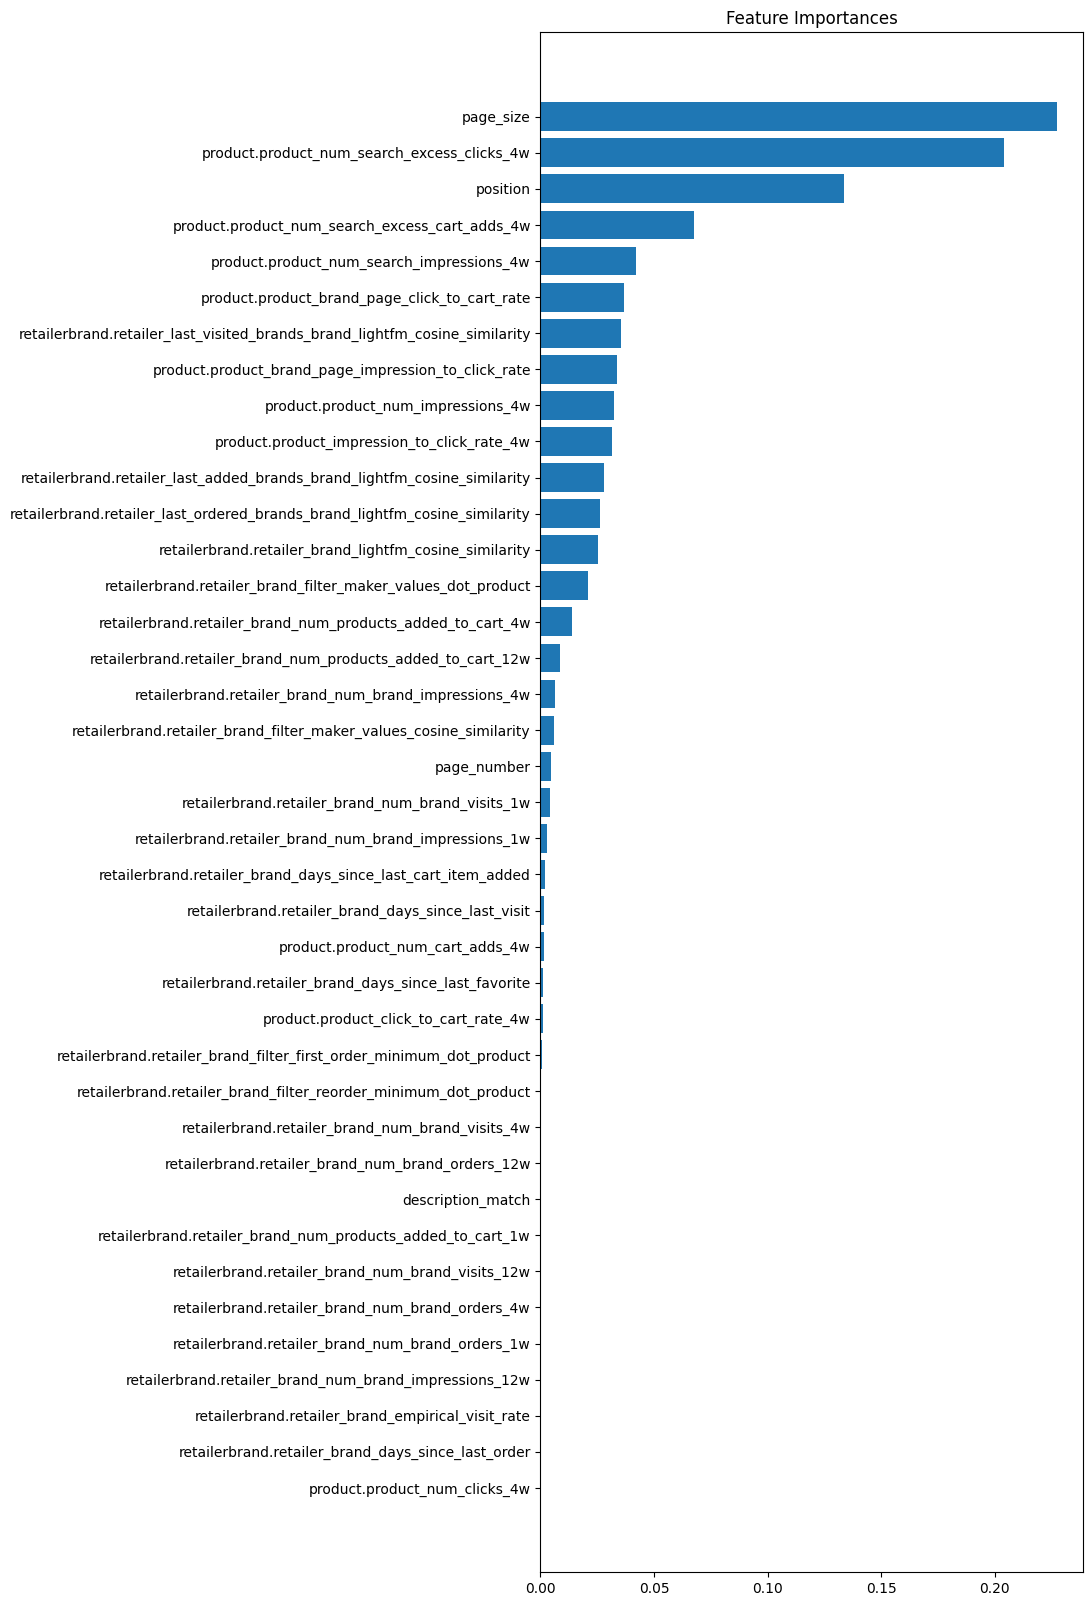

In [15]:
# print(f"\n --- Top 5 Features ------ ")
# for i in range(len(X.columns)):
#     print(f"{featureImportances[i][0]}:\t{round(featureImportances[i][1], 4)}")

featureImportances = list(zip(X.columns, grid_search.best_estimator_.feature_importances_))
featureImportances.sort(key=lambda x: x[1], reverse=False)                  
featureImportances = pd.DataFrame(featureImportances, columns=['feature', 'importance'])

plt.figure(figsize=(7, 20))
plt.barh(featureImportances['feature'], featureImportances['importance'])
plt.title('Feature Importances')
plt.plot()